In [2]:
pip install openeo --upgrade

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 6.9 MB/s  0:00:00

   ------ --------------------------------- 1/6 [oschmod]
   ------ --------------------------------- 1/6 [oschmod]
   ------------- -------------------------- 2/6 [pystac]
   ------------- -------------------------- 2/6 [pystac]
   ------------- -------------------------- 2/6 [pystac]
   ------------- -------------------------- 2/6 [pystac]
   ------------- -------------------------- 2/6 [pystac]
   -------------------- ------------------- 3/6 [deprecated]
   -------------------------- ------------- 4/6 [xarray]
   -------------------------- ------------- 4/6 [xarray]
   -------------------------- ------------- 4/6 [xarray]
   -------------------------- ------------- 4/6 [xarray]
   -------------------------- ------------- 4/6 [xarray]
   -------------------------- ------------- 4/6 [xarray]
   -------------------------- ------------- 4/6 [xarr

In [3]:
pip install xarray --upgrade

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------------------------------ --------- 1.0/1.4 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 10.0 MB/s  0:00:00

  Attempting uninstall: packaging

    Found existing installation: packaging 23.2

    Uninstalling packaging-23.2:

      Successfully uninstalled packaging-23.2

   ---------------------------------------- 0/2 [packaging]
  Attempting uninstall: xarray
   ---------------------------------------- 0/2 [packaging]
   -------------------- ------------------- 1/2 [xarray]
    Found existing installation: xarray 2025.1.1
   -------------------- ------------------- 1/2 [xarray]
    Uninstalling xarray-2025.1.1:
   -------------------- ------------------- 1/2 [xarray]
      Successfully uninstalled xarray-2025.1.1
   -------------------- ------------------- 1/2 [xarray]
   -------------------- ------------------- 1/2 [xarray]
   -------------------- ------------------- 1/2 [

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openeo 0.45.0 requires xarray<2025.01.2,>=0.12.3, but you have xarray 2025.10.1 which is incompatible.


In [31]:
#imports
import pandas as pd
import os
import glob

import openeo
import xarray
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Point
from shapely.ops import transform

from torch.utils.data import DataLoader, Dataset

# 1. Data Loading

In [32]:
def create_bbox_from_radius(lon, lat, radius_meters):
    """
    Erstellt eine Bounding Box aus einem Mittelpunkt (lon, lat) und einem Radius in Metern.
    """
    # Definiere die Projektionen: WGS84 (lat/lon) und eine metrische Projektion (Mercator)
    wgs84 = pyproj.CRS("EPSG:4326")
    mercator = pyproj.CRS("EPSG:3857")

    # Erstelle einen Transformer, um zwischen den Projektionen zu wechseln
    project_to_mercator = pyproj.Transformer.from_crs(wgs84, mercator, always_xy=True).transform
    project_to_wgs84 = pyproj.Transformer.from_crs(mercator, wgs84, always_xy=True).transform

    # Erstelle einen Punkt und projiziere ihn in das metrische System
    point_wgs84 = Point(lon, lat)
    point_mercator = transform(project_to_mercator, point_wgs84)

    # Erstelle einen Puffer (Kreis) um den metrischen Punkt
    buffer_mercator = point_mercator.buffer(radius_meters)

    # Projiziere den Puffer zurück zu WGS84
    buffer_wgs84 = transform(project_to_wgs84, buffer_mercator)
    
    # Gib die Grenzen (Bounds) des Puffers zurück
    return buffer_wgs84.bounds

In [33]:
path_root = ("./data/")

In [28]:
class Dataset_Sen2(Dataset):
    '''Dataset Loading - Loads the dataset and the corresponding Sentinel-2 images from Copernicus.

    Returns:
        ds: xarray datacube containing the Sentinel-2 images.
    '''

    def __init__(self, root):
        self.root = root # Root path where the dataset is located
        #read dataset
        self.dataframe = pd.read_csv(os.path.join(self.root, "HyG_20240220.csv"), sep=",",  encoding='utf-8')
        #filter dataset
        self.dataframe = self.dataframe[self.dataframe['NAME'] == 'Missouri-Marias']
        self.dataframe = self.dataframe.reset_index(drop=True)
        self.dataframe = self.dataframe.head(3) #limit to first 3 entries for testing

        #get the IDs of the points in the river
        self.IDs = self.dataframe['Gage_ID'].to_list()
        #get the longitude and latitude of the specific river point from the dataset
        self.lat = self.dataframe['lat_degN'].to_list()
        self.lon = self.dataframe['lon_degE'].to_list()
        #define a radius for defining the bounding box around the specific point
        radius = 5000
        # calculate bounding boxes for each point and store them in a dictionary
        bbox_keys = ("west", "south", "east", "north")
        self.bboxes_dict = {
            id:
                dict(zip(bbox_keys, create_bbox_from_radius(self.lon, self.lat, radius)))
                for id, self.lon, self.lat in zip(self.IDs, self.lon, self.lat)
        }
        
        #get connection to Copernicus API
        self.connection = openeo.connect("openeofed.dataspace.copernicus.eu").authenticate_oidc()

        #load the datacube with Sentinel-2 data from API and download it
        for i, bbox in enumerate(self.bboxes_dict.values()):
            print(f"Loading datacube for ID: {str(self.IDs[i])} with bbox: {str(bbox)}")
            self.datacube = self.connection.load_collection(
            "SENTINEL2_L2A",
            temporal_extent=("2024-05-01", "2024-05-05"),
            spatial_extent={
                "west": bbox["west"],
                "south": bbox["south"],
                "east": bbox["east"],
                "north": bbox["north"],
                "crs": "EPSG:4326",
            },
            bands=["B04", "B03", "B02", "SCL"],
            max_cloud_cover=50,
        )
            #download the datacube
            out_filename = f"sentinel2{self.IDs[i]}.nc"
            self.datacube.download(os.path.join(self.root, out_filename))

    def __getitem__(self, idx):
        #load the datacubes
        file_path = glob.glob(os.path.join(self.root, "sentinel2*.nc"))[idx]
        comb_dc = xarray.open_mfdataset(file_path, parallel=True) # using Dask for lazy loading - library for parallel computing
        return comb_dc, self.bboxes_dict, self.IDs

    def __len__(self):
        # return the length of the dataset
        return len(self.dataframe)

dataset = Dataset_Sen2(path_root)

Authenticated using refresh token.
Loading datacube for ID: 6054500 with bbox: {'west': -111.46521576420595, 'south': 46.11547286400523, 'east': -111.375384235794, 'north': 46.17770954473375}
Loading datacube for ID: 6057000 with bbox: {'west': -111.57601576420596, 'south': 46.30367936731321, 'east': -111.48618423579401, 'north': 46.36570304643023}
Loading datacube for ID: 6058900 with bbox: {'west': -112.04181576420598, 'south': 46.33119496603633, 'east': -111.95198423579403, 'north': 46.3931874485023}


# 2. Explore the data

In [29]:
print(len(dataset))

3


In [34]:
datacube, bboxes_dict, IDs = dataset[0]

ModuleNotFoundError: No module named 'dask'

In [ ]:
datacube_A = comb_dc.sel(
    lon=slice(location_A_bbox["west"], location_A_bbox["east"]),
    lat=slice(location_A_bbox["north"], location_A_bbox["south"]) # Bei Lat oft von Nord nach Süd
)

AttributeError: 'Dataset_Sen2' object has no attribute 'compute'

In [ ]:
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = dataset[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(vmin=0, vmax=2000, ax=axes[0])
data[{"t": -1}].plot.imshow(vmin=0, vmax=2000, ax=axes[1]);

TypeError: list indices must be integers or slices, not list

In [28]:
data = datacube.min_time()

In [29]:
data.download('min.nc')

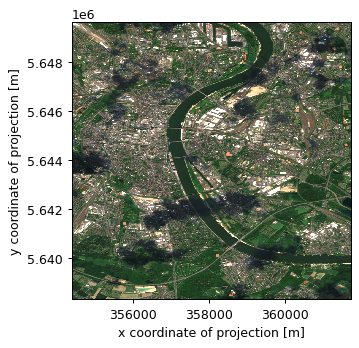

In [36]:
ds = xarray.load_dataset("min.nc")
# Convert xarray DataSet to a (bands, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, ax = plt.subplots(ncols=1, figsize=(4, 4), dpi=90)
data.plot.imshow(vmin=0, vmax=2000, ax=ax)

# 3. Create water mask with DeepLabV3+

# 4. Calculate river width 

# 5. Construct the cross-section

## Water masking

In [77]:
composite = datacube.max_time()

In [78]:
composite.download("load-composite.nc")

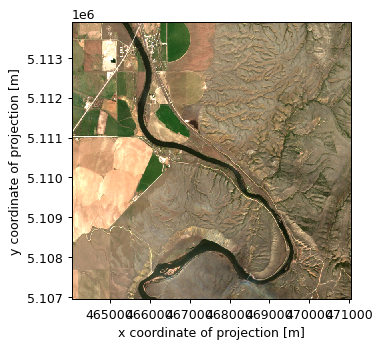

In [79]:
ds = xarray.load_dataset("load-composite.nc")
# Convert xarray DataSet to a (bands, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, ax = plt.subplots(ncols=1, figsize=(4, 4), dpi=90)
data.plot.imshow(vmin=0, vmax=2000, ax=ax)

In [80]:
# Select the "SCL" band from the data cube
scl_band = datacube.band("SCL")
# Build mask to mask out everything but class 6
mask = (scl_band != 6)

In [81]:
mask_resampled = mask.resample_cube_spatial(datacube)
# Apply the mask to the `datacube`
cube_masked = datacube.mask(mask_resampled)

In [82]:
cube_masked.max_time().download("water_mask.nc")

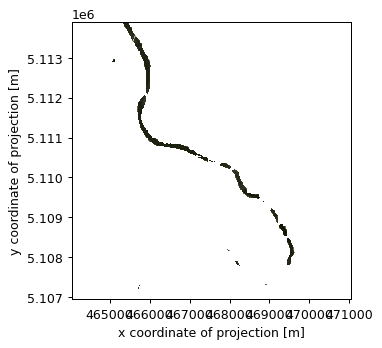

In [83]:
ds = xarray.load_dataset("water_mask.nc")
# Convert xarray DataSet to a (bands, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, ax = plt.subplots(ncols=1, figsize=(4, 4), dpi=90)
data.plot.imshow(vmin=0, vmax=2000, ax=ax);